<a href="https://colab.research.google.com/github/ROROZOA7/OpenLearning4DeepRecsys/blob/master/v2.5_ML20M%20optimizing%20cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import psutil
# gives a single float value
print(psutil.cpu_percent())
# gives an object with many fields
print(psutil.virtual_memory())
# you can convert that object to a dictionary print(dict(psutil.virtual_memory()._asdict()))
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

22.7
svmem(total=13617745920, available=12205932544, percent=10.4, used=1215897600, free=10447679488, active=1563766784, inactive=1392152576, buffers=110153728, cached=1844015104, shared=1220608, slab=130682880)
10.4
89.63254723436637


In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import gc

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

In [3]:
tf.__version__

'2.8.0'

In [4]:
itemCol = 'movieId'
userCol = 'userId'

In [5]:
# install ML20
from urllib.request import urlretrieve
from zipfile import ZipFile
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-20m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

In [6]:
# DGX setup
fpath = "./ml-20m" 

#colab setup
# from google.colab import drive
# drive.mount('/content/gdrive')
# fpath = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m"

In [7]:
# Loading data
ratings = pd.read_csv(fpath+'/ratings.csv')
ratings.sample(3)

,userId,movieId,rating,timestamp
11364556,78453,3198,4.0,1019953936
17081003,118174,1208,3.0,930744468
859647,5743,4975,2.5,1161207601


In [8]:
ratings_item_count = ratings.groupby([itemCol]).size().to_frame('nr_of_ratings').reset_index()
ratings_item_count = ratings_item_count.sort_values(by=['nr_of_ratings'], ascending=False)
# top 5000 movie
top_movies = ratings_item_count['movieId'].tolist()[:5000]
# take ratings for top 5000 movie
ratings = ratings[ratings['movieId'].isin(top_movies)]
from sklearn.preprocessing import LabelEncoder
# label encoder label
movie_id_encoder = LabelEncoder()
ratings['movieId'] = movie_id_encoder.fit_transform(ratings['movieId'])

In [9]:
print(len(set(ratings['movieId'].tolist())))
print(set(ratings['movieId'].tolist()))

5000
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

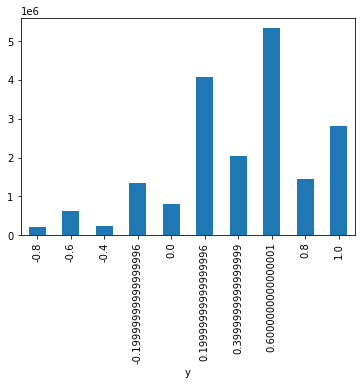

In [10]:
# Normalize rating về dạng -1 -> 1 (-1 = ghét, 1 = thích)
ratings["y"] = ratings["rating"]/2.5-1

# Kiểm tra rating trong khoảng -1 -> 1
ratings.groupby("y")["y"].count().plot(kind='bar')

In [11]:
# Loading movie
movies = pd.read_csv(fpath+'/movies.csv')
movies["year"]=movies["title"].apply(lambda x: x[-5:-1])
movies["genres"] = movies["genres"].apply(lambda x: ' ' if x == '(no genres listed)' else ' '.join(x.split('|')) )
movies["title"]= movies["title"].apply(lambda x: x[0:-7])
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji,Adventure Children Fantasy,1995
2,3,Grumpier Old Men,Comedy Romance,1995
3,4,Waiting to Exhale,Comedy Drama Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


# Model v2.3
Sử dụng constrastive loss thay cho onehot

In [12]:
# Chia dữ liệu thành các tập cho model clustering, nhãn recommendation và test
#     warm_up_mask: ratings đã quan sát
#     target: rating dùng để đánh giá kết quả recommend của module recommend cho từng người dùng
#     test: đánh giá độc lập
# TODO: chia tập dữ liệu theo user-wise => đánh giá với những user hoàn toàn mới thì model có học được không?
# v2.1. gộp warm_up và mask thành 1
def dataset_split(ratings):
    train, test = train_test_split(ratings, test_size= 0.25)
    warm_up_mask, target = train_test_split(train, test_size= 0.25)
    return warm_up_mask, target, test

warm_up_mask, target, test = dataset_split(ratings)

In [13]:
# Kiểm tra số lượng ratings
warm_up_mask.shape[0], target.shape[0], test.shape[0]

(10657298, 3552433, 4736577)

In [14]:
# v2.2: chỉ groupby, không padding
def get_interaction_set(interaction, max_item = None, top_k_item = None):
    """
    Input:
        interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
        max_item: int: item num limit
    Output:
        df, itemCol: list, y: list, itemCol_str: string, userCol as index
        list item sắp xếp theo giảm dần độ lớn rating
    """
    items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
    if top_k_item is not None:
        top_items = items.head(top_k_item).index
        interaction = interaction[interaction[itemCol].isin(top_items)]
    else:
        top_items = items.index

    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    interaction = interaction.reindex(rindex)
    ui_interaction = interaction
    # Chuyển thành warm-up set theo từng user
    interaction = interaction.groupby("userId").agg({itemCol:list, "y":list})

    # Giới hạn độ dài warm_up size
    if max_item is not None:
        interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
        interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])

    return interaction, top_items,ui_interaction

top_k_item = 5000
wu_size = 200
mask_size = 50
max_item = wu_size + mask_size

interac_df, top_items, ui_interaction = get_interaction_set(warm_up_mask[warm_up_mask[userCol]<3000]
                    , max_item = max_item
                    , top_k_item = top_k_item )
# interac_df

### test mlm

In [15]:
warm_up, mask = model._wu_mask_split(interac_df.sample(frac=1), mask_ratio = 0.25)
# add padding convert to vector 200
wu_items, wu_ratings = model._preprocess(warm_up, wu_size)
mask_item, mask_ratings = model._preprocess(mask, wu_size)

NameError: ignored

In [ ]:
print(type(wu_items))
print(type(mask_item))
print(type(wu_ratings))
print(type(mask_ratings))

In [ ]:
# set mask token id = 99999
mask_token_id = 99999
def _preprocess2(inputs, padding_size = 100):
    """
    Padding về wu_size và mask_size, convert list of items => string of items
    batch_inputs: df: itemStr, y"""

    def padding_list(list_item, wu_size, value=0, is_padding=True):
        series_item1 = list_item[0:wu_size]
        if is_padding:
            series_item1 = series_item1+[value]*(wu_size-len(series_item1))
        return series_item1

    items_list, ratings_list = inputs[itemCol], inputs["y"]

    items   =   np.stack(items_list.apply(lambda x: padding_list(x, padding_size, value=mask_token_id)))
    ratings =   np.stack(ratings_list.apply(lambda x: padding_list( x, padding_size)))

    return items, ratings


In [ ]:
a, b = _preprocess2(interac_df, 200)

In [ ]:
print(type(a))
print(a[0])
print(b[0])
print(a.shape)
print(b.shape)
print(type(b))

In [ ]:
# test mask layer

# set mask token id = 99999
mask_token_id = 99999
def get_masked_input_and_labels(batch_inputs, masked_rate=0.15):
    input_items, input_ratings = batch_inputs[itemCol], batch_inputs["y"]
    encoded_items, encoded_ratings = _preprocess2(interac_df, wu_size)
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_items.shape) < masked_rate
    # Do not mask special tokens
    # inp_mask[encoded_items <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_items.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_items[inp_mask]

    # Prepare input
    encoded_items_masked = np.copy(encoded_items)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_items.shape) < 0.90)
    encoded_items_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    #---- Todo: set 10% masked random
    # # Set 10% to a random token
    # inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_items.shape) < 1 / 9)
    # encoded_items_masked[inp_mask_2random] = np.random.randint(
    #     3, mask_token_id, inp_mask_2random.sum()
    # )
    # print(inp_mask_2random)
    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    items_masked_labels = np.copy(encoded_items)


    # mask rating 
    encoded_ratings_masked = np.copy(encoded_ratings)
    encoded_ratings_masked[inp_mask_2mask] = 0
    ratings_mask_labels = np.copy(encoded_ratings)
    

    return (encoded_items_masked, items_masked_labels, sample_weights), (encoded_ratings_masked,ratings_mask_labels,sample_weights )


In [ ]:
u_masked, r_masked = get_masked_input_and_labels(interac_df)
masked_items, wu_items, masked_position = u_masked
masked_ratings, wu_ratings, _ = r_masked
# a, b = _preprocess2(interac_df, 200)

In [ ]:
wu_test = pd.Series(wu_items.tolist())
wu_test   = wu_test.apply(lambda x: ' '.join(list([str(i) for i in x])))
wu_test.head(5)

In [ ]:
# wu_test = pd.Series(wu_items) 
with tf.GradientTape() as tape:
    # Interaction embedding
    wu_vec = model.encoder([wu_test, wu_ratings])
    # mask_vec = model.encoder([masked_items, masked_ratings])
    # negative_vec = model.encoder([negative_items, negative_ratings])


In [ ]:
print(wu_vec)

In [ ]:
# print(test)
print(u_masked[0].shape)
print(u_masked[0][0])
print(r_masked[0][0])

In [104]:
print(top_items)
print(len(top_items))

Int64Index([ 239,  290,  257,  476,  389,  210,   93,  473, 1741,  432,
            ...
            3432, 1669, 4407, 2846, 2473, 3930, 4914, 4762, 3602, 3372],
           dtype='int64', name='movieId', length=5000)
5000


### Class  model

In [15]:
# Khởi tạo cấu hình: xác định encoder, decoder, mapping dims
class Efficient_Rec(tf.keras.Model):
  def __init__(self, encoder, decoder, reps, use_tf_function=False):
    super().__init__()
    self.use_tf_function = use_tf_function

    self.encoder = encoder
    self.decoder = decoder
    self.reps = reps

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [16]:
def _wu_mask_split(self, batch_inputs, mask_ratio = 0.25):
    "Chia ratings và items thành mask, warm up"
    input_items, input_ratings = batch_inputs[itemCol], batch_inputs["y"]

    def list_split(input, mask_ratio = 0.25, seed= 42):
        return train_test_split(input[0:(wu_size+mask_size)], test_size= mask_ratio, random_state=seed)

    seed = random.randint(1, 100)
    items = input_items.apply(lambda x: list_split(x, mask_ratio, seed))
    ratings = input_ratings.apply(lambda x: list_split(x, mask_ratio, seed))

    wu_item_list = items.apply(lambda x: x[0])
    mask_item_list = items.apply(lambda x: x[1])

    wu_rating_list = ratings.apply(lambda x: x[0])
    mask_rating_list = ratings.apply(lambda x: x[1])
    return (wu_item_list, wu_rating_list), (mask_item_list, mask_rating_list)

Efficient_Rec._wu_mask_split = _wu_mask_split

In [17]:
# set mask token id = 99999
mask_token_id = 99999
def _preprocess2(self, inputs, padding_size = 100):
    """
    Padding về wu_size và mask_size, convert list of items => string of items
    batch_inputs: df: itemStr, y"""

    def padding_list(list_item, wu_size, value=0, is_padding=True):
        series_item1 = list_item[0:wu_size]
        if is_padding:
            series_item1 = series_item1+[value]*(wu_size-len(series_item1))
        return series_item1

    items_list, ratings_list = inputs[itemCol], inputs["y"]

    items   =   np.stack(items_list.apply(lambda x: padding_list(x, padding_size, value=mask_token_id)))
    ratings =   np.stack(ratings_list.apply(lambda x: padding_list( x, padding_size)))

    return items, ratings
Efficient_Rec._preprocess2 = _preprocess2

In [18]:
def _preprocess(self, inputs, padding_size = 100):
    """
    Padding về wu_size và mask_size, convert list of items => string of items
    batch_inputs: df: itemStr, y"""

    def padding_list(list_item, wu_size, value=0, is_padding=True):
        series_item1 = list_item[0:wu_size]
        if is_padding:
            series_item1 = series_item1+[value]*(wu_size-len(series_item1))
        return series_item1

    items_list, ratings_list = inputs

    items   = items_list.apply(lambda x: ' '.join(list([str(i) for i in x])))
    ratings =   np.stack( ratings_list.apply(lambda x: padding_list( x, padding_size  ) ) )

    return items, ratings

Efficient_Rec._preprocess = _preprocess

In [19]:
mask_token_id = 99999
def get_masked_input_and_labels(self, batch_inputs, masked_rate=0.15):
    input_items, input_ratings = batch_inputs[itemCol], batch_inputs["y"]
    encoded_items, encoded_ratings = self._preprocess2(interac_df, wu_size)
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_items.shape) < masked_rate
    # Do not mask special tokens
    # inp_mask[encoded_items <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_items.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_items[inp_mask]

    # Prepare input
    encoded_items_masked = np.copy(encoded_items)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_items.shape) < 0.90)
    encoded_items_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    #---- Todo: set 10% masked random
    # # Set 10% to a random token
    # inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_items.shape) < 1 / 9)
    # encoded_items_masked[inp_mask_2random] = np.random.randint(
    #     3, mask_token_id, inp_mask_2random.sum()
    # )
    # print(inp_mask_2random)
    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    items_masked_labels = np.copy(encoded_items)


    # mask rating 
    encoded_ratings_masked = np.copy(encoded_ratings)
    encoded_ratings_masked[inp_mask_2mask] = 0
    ratings_mask_labels = np.copy(encoded_ratings)
    

    return (encoded_items_masked, items_masked_labels, sample_weights), (encoded_ratings_masked,ratings_mask_labels,sample_weights )
Efficient_Rec.get_masked_input_and_labels = get_masked_input_and_labels

In [20]:
# Thực hiện training
def _train_step(self, inputs):
    warm_up, mask = self._wu_mask_split(inputs, mask_ratio = 0.25)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, mask_size)

    with tf.GradientTape() as tape:
        # Encode the input
        wu_vec = self.encoder([wu_items, wu_ratings])
        y_pred = self.reps(wu_vec)

        # Encde the output
        mask_vec = self.decoder([mask_item, mask_ratings])

        average_loss = self.loss(mask_vec, y_pred)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    # print(gradients)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._train_step = _train_step

In [21]:
# Thực hiện minibatch training
def _batch_train_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    for chunk in chunks:
        self._train_step(chunk)

Efficient_Rec._batch_train_step = _batch_train_step

In [22]:
# Thực hiện training
# TODO: sửa lại pd shift thành np.roll
def _mlm_train_step(self, inputs):
    u_masked, r_masked = self.get_masked_input_and_labels(inputs)
    masked_items, wu_items, masked_position = u_masked
    masked_ratings, wu_ratings, _ = r_masked
    # convert to pandas series for vectorize layer
    # Anchor
    wu_items = pd.Series(wu_items.tolist())
    wu_items   = wu_items.apply(lambda x: ' '.join(list([str(i) for i in x])))
    # Positive
    masked_items = pd.Series(masked_items.tolist())
    masked_items   = masked_items.apply(lambda x: ' '.join(list([str(i) for i in x])))
    # Negative
    negative_items = wu_items.shift(1, axis=0, fill_value=['0 ']) #np.roll( wu_items, shift= 1, axis=0)
    negative_ratings =  np.roll( wu_ratings, shift= 1, axis=0)

    with tf.GradientTape() as tape:
        # Interaction embedding
        wu_vec = self.encoder([wu_items, wu_ratings])
        mask_vec = self.encoder([masked_items, masked_ratings])
        negative_vec = self.encoder([negative_items, negative_ratings])
        average_loss = self.loss(wu_vec, mask_vec, negative_vec) #- 0.1*np.mean([tf.linalg.norm(x) for x in self.trainable_variables])
        # test based loss
        # average_loss = self.loss(wu_vec, mask_vec)

    # Apply an optimization step
    variables = self.trainable_variables 
    # print("Variables", variables)
    gradients = tape.gradient(average_loss, variables)
    # print('gradients before clipping = ', gradients)
    gradients = [0.01 if gradient is None else tf.clip_by_value(gradient, -1., 1.) for gradient in gradients]
    # gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
    # print("gradients", gradients)
    self.optimizer.apply_gradients(zip(gradients, variables))
    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._mlm_train_step = _mlm_train_step

In [23]:
# Thực hiện minibatch training
def _mlm_train_minibatch_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    losses = []
    for chunk in chunks:
        loss = self._mlm_train_step(chunk)
        losses.append(loss["batch_loss"].numpy())
        print(loss)
    return np.mean(losses)

Efficient_Rec._mlm_train_minibatch_step = _mlm_train_minibatch_step

In [24]:
# Thực hiện training
# TODO: sửa lại pd shift thành np.roll
def _constrastive_train_step(self, inputs):
    warm_up, mask = self._wu_mask_split(inputs.sample(frac=1), mask_ratio = 0.25)
    # add padding convert to vector 200
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, wu_size)

    negative_items = wu_items.shift(1, axis=0, fill_value=['0 ']) #np.roll( wu_items, shift= 1, axis=0)
    negative_ratings =  np.roll( wu_ratings, shift= 1, axis=0)

    with tf.GradientTape() as tape:
        # Interaction embedding
        wu_vec = self.encoder([wu_items, wu_ratings])
        mask_vec = self.encoder([mask_item, mask_ratings])
        negative_vec = self.encoder([negative_items, negative_ratings])


        average_loss = self.loss(wu_vec, mask_vec, negative_vec) #- 0.1*np.mean([tf.linalg.norm(x) for x in self.trainable_variables])

    # Apply an optimization step
    variables = self.trainable_variables 
    # print("Variables", variables)
    gradients = tape.gradient(average_loss, variables)
    # print('gradients before clipping = ', gradients)
    gradients = [0.01 if gradient is None else tf.clip_by_value(gradient, -1., 1.) for gradient in gradients]
    # gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
    # print("gradients", gradients)
    self.optimizer.apply_gradients(zip(gradients, variables))
    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._constrastive_train_step = _constrastive_train_step

In [25]:
# Thực hiện minibatch training
def _constrastive_train_minibatch_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    losses = []
    for chunk in chunks:
        loss = self._constrastive_train_step(chunk)
        losses.append(loss["batch_loss"].numpy())
        print(loss)
    return np.mean(losses)

Efficient_Rec._constrastive_train_minibatch_step = _constrastive_train_minibatch_step

### Xây dựng encoder model
Encoder =  interaction embedding + user feature embedding<br> 
interaction embedding = sum( interaction embedding các item i)<br> 
interaction embedding item i = rating x (embedding id sản phẩm + embedding item feature)<br>



In [26]:
%%time
# Vectorize (encode + padding) item list
max_vocab_size = len(top_items) # nếu số item có <= top_k_item => lấy số lượng item max
items_str = ' '.join([str(i) for i in top_items])
itemStr = itemCol+"_str"

vectorizer = layers.TextVectorization( max_tokens= top_k_item, split='whitespace', output_sequence_length= wu_size, name = 'vectorizer')
vectorizer.adapt( [items_str] ) 

CPU times: user 475 ms, sys: 20.7 ms, total: 495 ms
Wall time: 732 ms


In [27]:
class Broadcasting_Multiply(tf.keras.layers.Layer):
    """Nhân 2 layers khác shape với nhau, trong đó:
    inputs=[layer1, layer2]
    layer1.shape = (None, n_item, n_feature)
    layer2.shape = (None, n_item)
    (Chú ý đúng thứ tự)
    """

    def call(self, inputs):
        x, y = inputs

        #we add the extra dimension:
        y = K.expand_dims(y, axis=-1)
        #we replicate the elements
        y = K.repeat_elements(y, rep=x.shape[2], axis=-1)

        return x * y

In [28]:
# Xây dựng mạng
embedding_size = 150
reps_size = 128
cluster_num = 40

@tf.function
def avg_layer(z):
    deno = tf.expand_dims(tf.cast(tf.math.count_nonzero(z[1], axis=1), tf.float32), -1)
    t = K.sum(z[0], axis=1)/deno
    t = tf.clip_by_value( t, -1, 1 )
    t = tf.where(tf.math.is_nan(t), tf.zeros_like(t), t)
    return t
    # if tf.reduce_sum(deno) >0 :
    #     return  
    # else:
    #     return K.sum(z[0], axis=1)


def interaction_embedding2():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size +2, output_dim= embedding_size, mask_zero= False, name='ei')(wi)
    wi = layers.Dense(embedding_size, activation='relu', name='di')(wi)

    wr = layers.Input(shape=(wu_size,), name='warm_up_ratings')

    ireps = Broadcasting_Multiply(name='mul')([wi, wr])
    # test: bỏ skip connection
    # uprofile = layers.Lambda(lambda z: avg_layer(z) )([ireps, wr])
    uprofile = layers.Lambda(lambda z: K.sum(z, axis=1) )(ireps)
    # uprofile = layers.LayerNormalization(name='norm')(uprofile)


    # uprofile = layers.Dense( reps_size, activation='relu', name='du1')(ireps)
    uprofile = layers.Dense( reps_size, activation='relu', name='du1')(uprofile)
    uprofile = layers.LayerNormalization(name='norm1')(uprofile)
    uprofile = layers.Dense( 64, activation='relu', name='du2')(uprofile)
    uprofile = layers.LayerNormalization(name='norm2')(uprofile)
    uprofile = layers.Dense( 64, activation='relu', name='du3')(uprofile)
    uprofile = layers.LayerNormalization(name='norm3')(uprofile)
    # uprofile = layers.BatchNormalization(name='norm')(uprofile)
    uprofile = layers.Dense(cluster_num, activation='softmax', name='clustering')(uprofile)
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[uprofile])
    return model

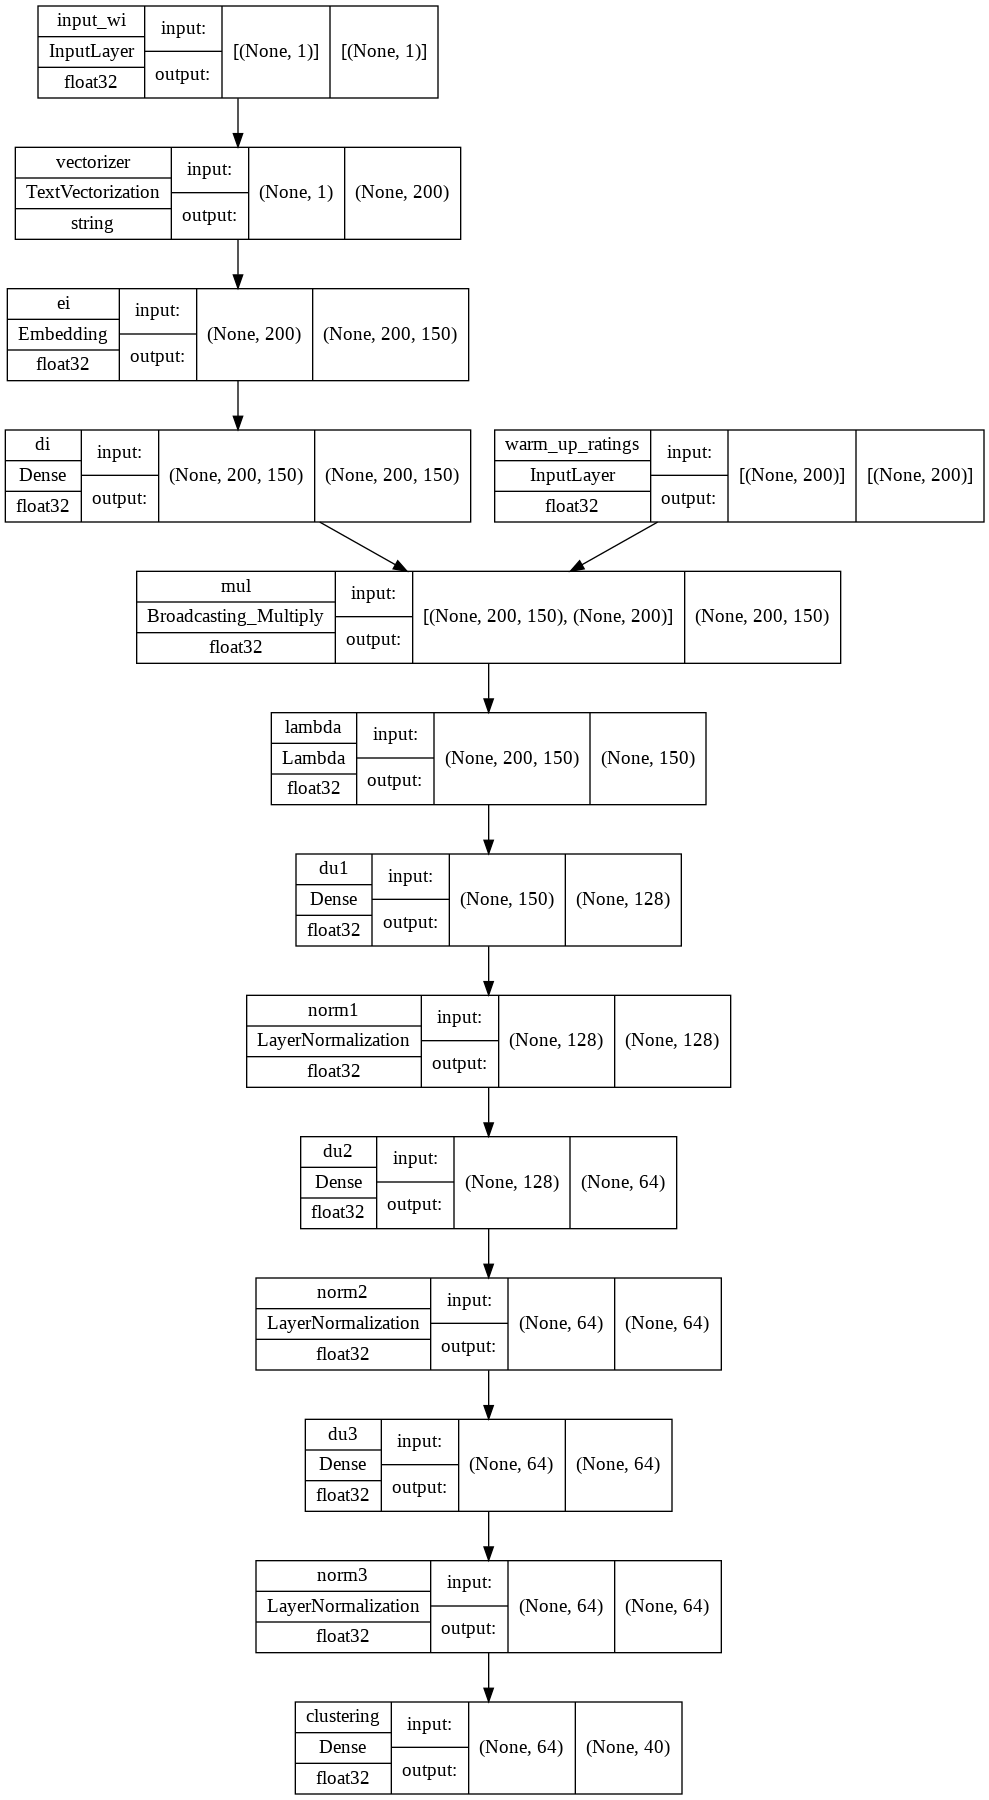

In [29]:
encoder = interaction_embedding2()
tf.keras.utils.plot_model( encoder ,show_shapes=True, show_dtype=True, show_layer_names=True)

In [30]:
# Note error: Đang bị Nan từ đoạn gradients, trước khi clipping thì cũng đã bị nan rồi , mặc dù loss != 0 nhưng gradient vẫn xuất hiện NaN

In [31]:
# def avg_layer(z):
#     print(tf.expand_dims(tf.cast(tf.math.count_nonzero(z[1], axis=1), tf.float32), -1))
#     deno = tf.expand_dims(tf.cast(tf.math.count_nonzero(z[1], axis=1), tf.float32), -1)
#     print("deno",deno)
#     # if deno >0 :
#     return  K.sum(z[0], axis=1)/deno
#     # else:
#     #     return K.sum(z[0], axis=1)

# input_wi = [" "]

# vectorizer = layers.TextVectorization( max_tokens= 5, split='whitespace', output_sequence_length= 3)
# vectorizer.adapt( ["2 1"] ) 

# wi = vectorizer(input_wi)
# print(wi)
# wi = layers.Embedding(input_dim= max_vocab_size, output_dim= 2, mask_zero= False, name='ei')(wi)
# print(wi)
# wi = layers.Dense(2, activation='relu', name='di', use_bias=0)(wi)
# print(wi)

# wr = np.array([0.,0.,0.])


# ireps = Broadcasting_Multiply(name='mul')([wi, wr])
# print(ireps)
# uprofile = layers.Lambda(lambda z: avg_layer(z) )([ireps, wr])
# print(uprofile)

In [32]:
# Kiểm tra tham số
# encode_model.summary()

In [33]:
# tf.keras.utils.plot_model( encode_model ,show_shapes=True, show_dtype=True, show_layer_names=True )

### Constrastive model

In [34]:
def constrastive_loss(margin=0.01):
    def compute_loss(wu_vec, mask_vec, negative_vec):
        ap_distance = tf.linalg.norm(wu_vec - mask_vec, axis=1)
        an_distance = tf.linalg.norm(wu_vec - negative_vec, axis=1)
        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        # print(wu_vec)
        loss = ap_distance - an_distance
        # print("Triplet loss",loss)
        loss = tf.maximum(loss + margin, 0.0)
        loss =tf.reduce_mean(loss)
        # print("Mean Loss", loss)
        return loss
    return compute_loss



In [35]:
def triplet_loss(margin=0.2):
    def compute_loss(wu_vec, mask_vec, negative_vec):
        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        # print(wu_vec)
        d_pos = tf.reduce_sum(tf.square(wu_vec - mask_vec), 1)
        # d_neg = tf.reduce_sum(tf.square(wu_vec - negative_vec), 1)

        # loss = tf.maximum(0., margin + d_pos - d_neg)
        # loss = tf.reduce_mean(loss)

        loss = tf.reduce_mean(d_pos)
        # print('dpos =',d_pos,', dneg=', d_neg, ',loss=', loss)
        return loss
    return compute_loss

In [36]:
def cossim(a, b):
    def l2(a):
        return tf.sqrt( tf.reduce_sum(tf.square(a), axis=1) )
    return tf.reduce_sum(tf.multiply(a, b), axis=1)/(l2(a)*l2(b))
    
def constrastive_loss(margin=0.01):
    def compute_loss(wu_vec, mask_vec, negative_vec):
        # ap_distance = tf.linalg.norm(wu_vec - mask_vec, axis=1)
        # an_distance = tf.linalg.norm(wu_vec - negative_vec, axis=1)
        ap_distance = 1-cossim(wu_vec , mask_vec)
        an_distance = 1-cossim(wu_vec , negative_vec)
        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        # print(loss)
        loss = tf.maximum(loss + margin, 0.)
        # tf.print(loss)
        loss =tf.reduce_mean(loss)
        return loss
    return compute_loss

def circle_loss(margin=0.01, gama=0.05):
    def compute_loss(wu_vec, mask_vec, negative_vec):
        sp = cossim(wu_vec , mask_vec)
        sn = cossim(wu_vec , negative_vec)

        loss = gama*tf.math.exp(tf.maximum(sn - sp + margin, 0))
        # loss = tf.math.log(1+ loss)
        loss = tf.reduce_mean(loss)

        return loss
    return compute_loss

def base_loss():
    def compute_loss(wu_vec, mask_vec):
        loss = 1-cossim(wu_vec , mask_vec)
        loss =tf.reduce_mean(loss)
        print("Mean Loss", loss)
        return loss
    return compute_loss

In [37]:
# hard triplet loss: Batch all strategy
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.cast(tf.equal(distances, 0.0), tf.float64)
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

In [38]:
# test distance function
# u_masked, r_masked = model.get_masked_input_and_labels(test_interac_df)
# masked_items, wu_items, masked_position = u_masked
# masked_ratings, wu_ratings, _ = r_masked
# wu_items = wu_items.astype('float')
# wu_items = tf.convert_to_tensor(wu_items)
# print(type(wu_items))
# dists = _pairwise_distances(wu_items)


In [39]:
%%time
# Kiểm tra số lượng ratings
warm_up_mask, target, test = dataset_split(ratings)
warm_up_mask.shape[0], target.shape[0], test.shape[0]
top_k_item = 5000
wu_size = 200
mask_size = 50
max_item = wu_size + mask_size
# Sample test
n_sample = 2000 

interac_df, top_items, ui_interaction = get_interaction_set(warm_up_mask[warm_up_mask[userCol]<n_sample]
                    , max_item = max_item
                    , top_k_item = top_k_item )
interac_df

CPU times: user 6.5 s, sys: 312 ms, total: 6.81 s
Wall time: 6.79 s


In [40]:
# Compile model
model = Efficient_Rec( encoder = interaction_embedding2(), 
                      reps = None, #get_reps_model(),
                      decoder = None ,# mask_label(),
                      use_tf_function=False)

# Configure the loss and optimizer
model.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    # loss=triplet_loss(margin=0.2)
    # loss =constrastive_loss(margin=0.01)
    loss = circle_loss(margin=0.1, gama=0.95)
    # loss = base_loss()
)

In [41]:
#  a = model._constrastive_train_minibatch_step( interac_df, batch_size = 512 )
#  print(a)
#  print(type(a))

In [42]:
gc.collect()

5023

In [43]:
%%time
epochs= 2
for n in range(epochs):
  batch_loss = model._mlm_train_minibatch_step( interac_df, batch_size = 512 )
  # batch_loss = model._constrastive_train_minibatch_step( interac_df, batch_size = 512 )
  print(n, "/", epochs, ": ", batch_loss)
  # print(model.layers[0].weights)
  # if batch_loss <= 0.01:
  #   break
gc.collect()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.97013664>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.96384835>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9647957>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9603406>}
0 / 2 :  0.96478033
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9566353>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9543407>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9526104>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9521343>}
1 / 2 :  0.9539302
CPU times: user 1min 35s, sys: 4.26 s, total: 1min 39s
Wall time: 54.6 s


In [44]:

ratings.isnull().values.any()

False

In [45]:
# inputs = interac_df
# warm_up, mask = model._wu_mask_split(inputs.sample(frac=1), mask_ratio = 0.25)
# wu_items, wu_ratings = model._preprocess(warm_up, wu_size)
# mask_item, mask_ratings = model._preprocess(mask, wu_size)

# negative_items = wu_items.shift(1, axis=0, fill_value=['0 ']) #np.roll( wu_items, shift= 1, axis=0)
# negative_ratings =  np.roll( wu_ratings, shift= 1, axis=0)

# with tf.GradientTape() as tape:
#     # Interaction embedding
#     wu_vec = model.encoder([wu_items, wu_ratings])
#     mask_vec = model.encoder([mask_item, mask_ratings])
#     negative_vec = model.encoder([negative_items, negative_ratings])

In [46]:
# a = wu_items
# b = wu_ratings

In [47]:
# wu_test = model.encoder([a, b])
# print(wu_test)

In [48]:
# wu_vec

In [49]:
# item_e = model.layers[0].get_weights()[1]
# print(item_e.shape)
# print(item_e)

In [50]:
# np.expand_dims(np.roll(interac_df["movieId"].apply(lambda x:' '.join([str(i) for i in x])), 1), -1)

In [51]:
# sample test classify (1000 sample)
test_interac_df = interac_df
print(test_interac_df.shape)
# group_scores = model.encoder(model._preprocess( [test_interac_df[itemCol], test_interac_df["y"]], padding_size = wu_size )).numpy()
# test mlm
u_masked, r_masked = model.get_masked_input_and_labels(test_interac_df)
masked_items, wu_items, masked_position = u_masked
masked_ratings, wu_ratings, _ = r_masked
# convert to pandas series for vectorize layer
# Anchor
wu_items = pd.Series(wu_items.tolist())
wu_items   = wu_items.apply(lambda x: ' '.join(list([str(i) for i in x])))
group_scores = model.encoder([wu_items, wu_ratings]).numpy()


df_cluster = test_interac_df
df_cluster['userId'] = test_interac_df.index
ugs= np.argmax(group_scores, axis=1)
df_cluster['cluster'] = ugs.tolist()
print(group_scores.shape)

(1999, 2)
(1999, 40)


In [52]:
# # Kiểm tra số user trong mỗi cụm có bị vón cục
# ugs= np.argmax(group_scores, axis=1)
# for i in range(50):
#     print(i,': ', np.sum(ugs==i) )

In [53]:
# 

In [54]:
# user embedding
df_cluster['userEmbedding'] = group_scores.tolist()
# items embedding
items_embedding = model.layers[0].get_weights()[1]
data = {'movieId': [i for i in range(items_embedding.shape[0])], 'itemEmbedding': items_embedding.tolist()}
df_items_embedding = pd.DataFrame(data=data)

In [55]:
df_items_embedding.head(3)

,movieId,itemEmbedding
0,0,"[0.019888270646333694, 0.007830630987882614, -..."
1,1,"[-0.02050367183983326, -0.030123833566904068, ..."
2,2,"[0.015122268348932266, 0.012916648760437965, 0..."


In [56]:
# mapping cluster - item -rating
df_cluster = df_cluster[['userId','cluster','userEmbedding']].reset_index(drop=True)
ui_interaction = ui_interaction.reset_index(drop=True)
# train_data = df_cluster.join(ui_interaction, on=['userId'], how='inner', rsuffix='L')
train_data = pd.merge(df_cluster, ui_interaction, left_on='userId', right_on='userId')
train_data = pd.merge(train_data, df_items_embedding, left_on='movieId', right_on='movieId')

In [97]:
train_data = train_data[['userEmbedding','itemEmbedding','y']]

In [105]:
train_data['userEmbedding'] = train_data['userEmbedding'].apply(lambda x: np.array(x))
train_data['itemEmbedding'] = train_data['itemEmbedding'].apply(lambda x: np.array(x))

In [106]:
a = train_data.to_numpy()

In [107]:
a[0]

array([array([0.05840223, 0.01797016, 0.00286902, 0.00742607, 0.03025228,
              0.00365915, 0.00862422, 0.00099681, 0.05786312, 0.00501627,
              0.01961047, 0.04308669, 0.00499034, 0.08085336, 0.00103751,
              0.00281538, 0.00252698, 0.07141741, 0.07469354, 0.00708044,
              0.01148912, 0.02513898, 0.00416685, 0.00105664, 0.00192731,
              0.01168735, 0.07310609, 0.0188573 , 0.00654617, 0.00987794,
              0.03473352, 0.03018073, 0.00348822, 0.0640927 , 0.05624553,
              0.05933531, 0.05692319, 0.01859435, 0.00705295, 0.00430835]),
       array([ 0.02819412,  0.03850031, -0.02849866, -0.04570402,  0.00966771,
               0.03824676, -0.02756546, -0.03995447,  0.03943603,  0.00631588,
               0.01553741, -0.01181477,  0.03472563, -0.04565341,  0.03710711,
               0.02041655, -0.00532066,  0.0457756 ,  0.01119437, -0.03946375,
              -0.03498353,  0.01133435,  0.03038811,  0.02963756, -0.00849579,
           

In [102]:
a = np.array(train_data[['userEmbedding','itemEmbedding']].values.tolist())
a = np.hstack((a[:, 0], a[:, 1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [104]:
print(type(a))
print(a.shape)
a[0]

<class 'numpy.ndarray'>
(310872,)


array([0.05840223, 0.01797016, 0.00286902, 0.00742607, 0.03025228,
       0.00365915, 0.00862422, 0.00099681, 0.05786312, 0.00501627,
       0.01961047, 0.04308669, 0.00499034, 0.08085336, 0.00103751,
       0.00281538, 0.00252698, 0.07141741, 0.07469354, 0.00708044,
       0.01148912, 0.02513898, 0.00416685, 0.00105664, 0.00192731,
       0.01168735, 0.07310609, 0.0188573 , 0.00654617, 0.00987794,
       0.03473352, 0.03018073, 0.00348822, 0.0640927 , 0.05624553,
       0.05933531, 0.05692319, 0.01859435, 0.00705295, 0.00430835])

In [96]:
print(type(a))
print(a.shape)

<class 'numpy.ndarray'>
(155436, 3)


In [85]:
from iteration_utilities import deepflatten

# l = [[1, 2, 3], [4, 5, 6], [7], [8, 9]]
b = a.flatten()

In [93]:
b = a.reshape(len(a),-1)
print(b[0])

[array([0.05840223, 0.01797016, 0.00286902, 0.00742607, 0.03025228,
        0.00365915, 0.00862422, 0.00099681, 0.05786312, 0.00501627,
        0.01961047, 0.04308669, 0.00499034, 0.08085336, 0.00103751,
        0.00281538, 0.00252698, 0.07141741, 0.07469354, 0.00708044,
        0.01148912, 0.02513898, 0.00416685, 0.00105664, 0.00192731,
        0.01168735, 0.07310609, 0.0188573 , 0.00654617, 0.00987794,
        0.03473352, 0.03018073, 0.00348822, 0.0640927 , 0.05624553,
        0.05933531, 0.05692319, 0.01859435, 0.00705295, 0.00430835])
 array([ 0.02819412,  0.03850031, -0.02849866, -0.04570402,  0.00966771,
         0.03824676, -0.02756546, -0.03995447,  0.03943603,  0.00631588,
         0.01553741, -0.01181477,  0.03472563, -0.04565341,  0.03710711,
         0.02041655, -0.00532066,  0.0457756 ,  0.01119437, -0.03946375,
        -0.03498353,  0.01133435,  0.03038811,  0.02963756, -0.00849579,
         0.00272872,  0.02017888,  0.01844304,  0.02345299,  0.01559341,
         0.044173

In [86]:
b.shape

(466308,)

In [62]:
train_data.shape

(155436, 3)

In [63]:
# test model 
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

# Here's a Deep Dumb MLP (DDMLP)
model = Sequential()
model.add(Dense(128, input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

print("Training...")
model.fit(X_train, y_train, nb_epoch=10, batch_size=16, validation_split=0.1, show_accuracy=True, verbose=2)

print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

NameError: ignored

In [ ]:
items_embedding = model.layers[0].get_weights()[1]
print(items_embedding)

In [ ]:
# Save embedding layer
# embeddings = model.get_layer('embeddings').get_weights()[0]
item_e = model.layers[0].get_weights()[1]
print(item_e.shape)
print(item_e)

// END constrastive model

In [ ]:
# Kiểm tra giá trị đầu ra
group_scores = model.encoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = wu_size )).numpy()
group_scores[0:3]

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
movies["genres_list"] = movies["genres"].apply(lambda x: x.split(' '))
movie_genres = movies.explode("genres_list")

In [ ]:
sample = warm_up_mask[warm_up_mask[userCol]<3000]


In [ ]:
gr = sample.merge(movie_genres, on="movieId").groupby(["userId", "genres_list"])["movieId"].count().reset_index()
gr["rank"] = gr.groupby("userId")["movieId"].rank(method='first', ascending=False)

labels = gr[gr["rank"] ==1].set_index("userId")
labels["pred_max_ind"] = np.argmax(group_scores, axis=1)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(group_scores) 

In [ ]:
import seaborn as sns

In [ ]:
df = pd.DataFrame()
df["y"] = labels["genres_list"]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                # palette=sns.color_palette("hls", 3),
                data=df)#.set(title="Iris data T-SNE projection") 

In [ ]:
# Kiểm tra số user trong mỗi cụm có bị vón cục
ugs= np.argmax(group_scores, axis=1)
for i in range(50):
    print(i,': ', np.sum(ugs==i) )


In [ ]:
# Sort theo user_group + draw sigmoid/softmax layer
plt.rcParams["figure.figsize"] = (20,10)
k =100
a = group_scores
print( np.max(a), np.mean(a), np.min(a) )
ind = np.argmax(group_scores, axis=1)
plt.imshow( a[np.argsort(ind)][0:k] )

In [ ]:
# np.argsort(a[1])

In [ ]:
# [np.isin(np.argsort(a[1]), np.array([0,1,2]) )]

In [ ]:
# Vẽ theo user_group
# user_groups = [ 32 ]
# a = group_scores
# ind = np.argmax(group_scores, axis=1)
# plt.imshow( a[ np.isin( ind, user_groups)] )

In [ ]:
# Vẽ y_true của các user chung group
# y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()
# y_true_ugrs = y_true[ np.isin( ind, user_groups)]

# for i in range(y_true_ugrs.shape[0]):
#     y_true_i = y_true_ugrs[i].reshape((50,100))
#     print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
#     plt.imshow( y_true_i)
#     plt.show()


In [ ]:
# plt.imshow(y_true[0].reshape(50, 100) )

In [ ]:
# y_true[0][y_true[0]!=0]

In [ ]:
# y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()[0:15]
# for i in range(y_true.shape[0]):
#     y_true_i = y_true[i].reshape((50,100))
#     print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
#     plt.imshow( y_true_i)
#     plt.show()

In [ ]:
# for i in range(group_scores.shape[0]):
#     plt.imshow( group_scores[i].numpy().reshape((5,10)) )
#     plt.show()

In [ ]:
# plt.imshow(y_true)

In [ ]:
import numpy as np
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

# define documents
docs = np.array(['Well done!',
        'Good work',
        'Great effort',
        'nice work',
        'Excellent!',
        'Weak',
        'Poor effort!',
        'not good',
        'poor work',
        'Could have done better.'])
# define class labels
labels = np.array([1,1,1,1,1,0,0,0,0,0])

# train the tokenizer
vocab_size = 50
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(docs)

# encode the sentences
encoded_docs = tokenizer.texts_to_sequences(docs)
print(encoded_docs)

# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length, name='embeddings'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)

# save embeddings
embeddings = model.get_layer('embeddings').get_weights()[0]
w2v_my = {}

for word, index in tokenizer.word_index.items():
    w2v_my[word] = embeddings[index]

print(w2v_my)

In [ ]:
print(type(model))
print(type(embeddings))

In [ ]:
gc.collect()